# NLP Analysis of WSJ titles

## Key objective
    - Export data from these findings for visualization on DataStudio

## Key questions
1. Which topics became more or less important over the period of the pandemic according the US?
    - When did they start reporting about vaccines? Or the pandemic?
    - How has that changed?
    
- Monthly review
    - Key topics ranked against each other
    - Distributions of topics when selected 
    
- Push analysis to BigQuery


In [1]:
# data science essentials

%autosave 60

import pandas as pd
import os

Autosaving every 60 seconds


## Big Query Authentication and Ingestion

In [2]:
# source: https://cloud.google.com/bigquery/docs/visualize-jupyter

# set global environment for authentication
credential_path = "C:\\Users\\nrosh\\Desktop\\Personal Coding Projects\\COVID19\\private\\covid19-2020-0fb8513fcbd8.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

%load_ext google.cloud.bigquery

In [3]:
%%bigquery df_bq
SELECT
  *
FROM
  `covid19-2020-272000.covid19.sentiments_magnitudes`

In [4]:
df = df_bq.copy()
df.head(5)

,date,headline,link,magnitude,score,source
0,2020-04-19,Make Sure to Include Digital Assets in Your Es...,https://www.wsj.com/articles/make-sure-to-incl...,0.0,0.0,wsj
1,2020-04-19,YouTube Spars With Auditor Over Transparency o...,https://www.wsj.com/articles/youtube-spars-wit...,0.0,0.0,wsj
2,2020-04-19,"Remembering Richard Brodsky, a Legislative Cha...",https://www.wsj.com/articles/remembering-richa...,0.0,0.0,wsj
3,2020-04-19,Sending Hospitals Into Bankruptcy,https://www.wsj.com/articles/sending-hospitals...,0.0,0.0,wsj
4,2020-04-19,China’s Hong Kong Roundup,https://www.wsj.com/articles/chinas-hong-kong-...,0.0,0.0,wsj


## Objectives
1. To determine key trends over the period of November 2019 to present
2. To predict which trends may rise when the pandemic ends

## Analytical procedure/methodology
1. Clean data -> produce unique headlines
    - Reorder by date
    - Understand overview
    - Remove duplicates produced by ETL configuration
    - Lower case headlines
2. Feature Engineering
    - Above average sentiment and emotional magnitude
    - Classification labels to differentiate periods of time by categories
3. Let's just, not go there right now...

## Data Cleansing
- Reorder by date
- Understand overview
- Remove duplicates produced by ETL configuration
- Lower case headlines

In [5]:
# Reorder dataframe by date
df.sort_values(by='date', inplace=True)
df

,date,headline,link,magnitude,score,source
14273,2019-11-08,JPMorgan Deal Shows Possible Path to Smaller F...,https://www.wsj.com/articles/jpmorgan-deal-sho...,0.4,0.4,wsj
4358,2019-11-08,Former Brazilian President ‘Lula’ da Silva Rel...,https://www.wsj.com/articles/brazilian-judge-o...,0.0,0.0,wsj
4359,2019-11-08,House Freedom Caucus Emerges as Trump’s Main D...,https://www.wsj.com/articles/house-freedom-cau...,0.0,0.0,wsj
4360,2019-11-08,"College Football’s Powers: Ohio State, Alabama...",https://www.wsj.com/articles/its-november-and-...,0.0,0.0,wsj
4361,2019-11-08,What’s News: World-Wide,https://www.wsj.com/articles/whats-news-world-...,0.0,0.0,wsj
...,...,...,...,...,...,...
146,2020-04-20,China Rolls Out Pilot Test of Digital Currency,https://www.wsj.com/articles/china-rolls-out-p...,0.3,0.3,wsj
145,2020-04-20,Cloud Companies Won’t Float Above Pandemic,https://www.wsj.com/articles/cloud-companies-w...,0.3,0.3,wsj
144,2020-04-20,Cloud Companies Won’t Float Above Pandemic,https://www.wsj.com/articles/cloud-companies-w...,0.3,0.3,wsj
172,2020-04-20,The Critical Variable in Keeping Coronavirus i...,https://www.wsj.com/articles/the-critical-vari...,0.6,0.6,wsj


In [6]:
# Change case of headlines to lower
df.headline = df.headline.apply(lambda x: str.lower(x))
df.head(5)

,date,headline,link,magnitude,score,source
14273,2019-11-08,jpmorgan deal shows possible path to smaller f...,https://www.wsj.com/articles/jpmorgan-deal-sho...,0.4,0.4,wsj
4358,2019-11-08,former brazilian president ‘lula’ da silva rel...,https://www.wsj.com/articles/brazilian-judge-o...,0.0,0.0,wsj
4359,2019-11-08,house freedom caucus emerges as trump’s main d...,https://www.wsj.com/articles/house-freedom-cau...,0.0,0.0,wsj
4360,2019-11-08,"college football’s powers: ohio state, alabama...",https://www.wsj.com/articles/its-november-and-...,0.0,0.0,wsj
4361,2019-11-08,what’s news: world-wide,https://www.wsj.com/articles/whats-news-world-...,0.0,0.0,wsj


In [7]:
rows = len(df.iloc[:, 1])

# mark repeated headlines
repeated_headlines = list(df.headline.value_counts()[df.headline.value_counts() > 1].index)
daily_editions = list(df.headline.value_counts()[df.headline.value_counts() > 3].index)
ind_repeated_headlines = df[df.headline.isin(repeated_headlines) == True].index

# feature engineering
df["fe_repeated_headlines"] = 0
df["fe_daily_editions"] = 0
df.loc[df.headline.isin(repeated_headlines) == True, "fe_repeated_headlines"] = 1
df.loc[df.headline.isin(daily_editions) == True, "fe_daily_editions"] = 1

# percentage of repeated articles
df.headline.value_counts()[df.headline.value_counts() > 1].apply(lambda x: " {} %".format(round(x*100/rows, 2)))

what’s news: business & finance                                 0.84 %
what’s news: world-wide                                         0.83 %
pepper...and salt                                               0.81 %
corrections & amplifications                                    0.63 %
photos of the week                                              0.12 %
                                                                ...   
biden and his vice presidential candidate                       0.01 %
muzzled activists are mixed blessing for companies              0.01 %
ruth’s chris steak house gets $20 million from aid program      0.01 %
china reveals probe of another top law-enforcement official     0.01 %
companies seek coronavirus tests for workers                    0.01 %
Name: headline, Length: 145, dtype: object

In [8]:
# get unique headlines and daily additions
df_unique = df[(df.fe_repeated_headlines == 0) | (df.fe_daily_editions == 1)]
df_unique.to_csv("data/unique_headlines.csv")

## Feature Engineering
- Above average sentiment and emotional magnitude
- Classification labels to differentiate periods of time by categories

In [9]:
df_fe = df_unique.copy()

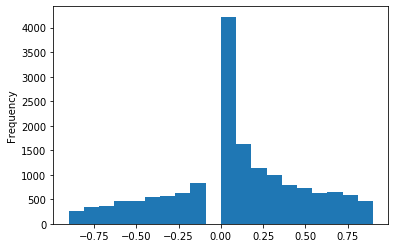

In [10]:
# observe distribution of sentiment over period of analysis
df_fe.score.plot.hist(bins=20)

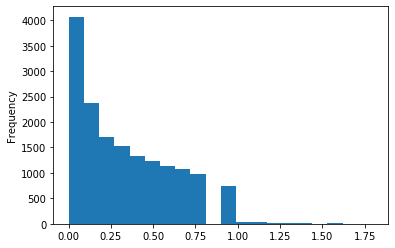

In [11]:
# observe distribution of magnitude over period of analysis
df_fe.magnitude.plot.hist(bins=20)

In [12]:
# findings
#     - score
#         - > 0.75  -> clearly positive
#         - < -0.75 -> clearly negative
#     - maginitude
#         - > 0.55  -> clearly midly expressive
#         - > 0.75  -> clearly highly expressive
        
df_fe.loc[df.score > 0.25, "fe_repeated_headlines"]

14273    0
16302    0
16301    0
5084     0
5085     0
        ..
301      1
183      1
182      1
179      1
178      1
Name: fe_repeated_headlines, Length: 4867, dtype: int64

In [13]:
_repeated_headlines = (df_fe.headline.value_counts() > 1).index


In [14]:
(df_fe.headline.value_counts() > 1).index

Index(['what’s news: business & finance', 'what’s news: world-wide',
       'pepper...and salt', 'corrections & amplifications',
       'photos of the week', 'correctionsamplifications',
       'what to know about the new coronavirus',
       'everything you need to know about the payments from the government',
       'all your coronavirus travel questions answered',
       'coronavirus spreads across china as confirmed cases triple',
       ...
       'holiday ad creep comes to influencer marketing',
       'carlos ghosn lawyer expresses ‘despair’ over japanese legal system',
       'only republicans need supreme court lists',
       'buttigieg distanced himself from liberals, and his campaign took off',
       'the labor virtues of growth',
       'distinguishing intimidation from protected free speech',
       'waymo raises $2.25 billion after courting outside investors for first time',
       'trump administration asks supreme court to reinstate blocked executions',
       'bloombe